# Census Bureau ACS 1-Year - ETL

This notebook extracts ACS Supplemental Data at the 1-year estimate level of analysis for targeted geographies at meso levels of analysis. 

This ETL process uses `COUNTY` as the reference geography from which all other geographies are based. For example: if the Texas county of Bexar is the `COUNTY` of reference, data associated with any `CD<current_congress>`, `PLACE`, `PUMA20`, and `ZIP` geographies that intersect with Bexar `COUNTY` (have any overlapping areas) will also be collected for analysis. 

*Note: running this notebook requires Shapefiles for `CD<current_congress>`, `COUNTY`, `PLACE` (Texas), and `PUMA20`.*

## Extract

### Preparation

In [ ]:
import pandas as pd
import geopandas as gpd
import warnings
import requests
import os
import sqlalchemy

In [ ]:
"""
user variables
"""
# if initial run (if True, initializes databases, etc.)
initializing = True
# reference county or counties, as FIPS state + county code
county_or_counties = ['48029']
# specify the data source by year
year = '2022'
"""
end user variables
"""

In [3]:
# list of variables for ACS SE data set: https://api.census.gov/data/2019/acs/acsse/variables.html - 49 most relevant data sets below
tables = {'population_by_sex': ['K200101'],
              'population_by_age': ['K200104'],
              'race': ['K200201'],
              'hispanic_or_latino_origin': ['K200301'],
              "citizenship_status": ['K200501'],
              "place_of_birth_within_US": ['K200503'],
              "geographic_mobility_within_US": ['K200701'],
              "means_of_transport_to_work": ['K200801'],
              "travel_time_to_work": ['K200802'],
              "household_type": ['K200901'],
              'marital_status': ['K201001'],
              'own_children_under_18_by_family_type': ['K201101'],
              'presence_of_people_over_60yo_by_household_type': ['K201102'],
              'school_enrollment_by_school_lvl_for_population_3yo+': ['K201401'],
              'educational_attainment_for_population_25yo+': ['K201501'],
              'household_language': ['K201601'],
              'poverty_status_past_12_months_by_age': ['K201701'],
              'ratio_income_to_poverty_past_12_months': ['K201702'],
              'poverty_status_by_household_type_past_12_months': ['K201703'],
              'disability_status_by_age': ['K201801'],
              'work_experience_by_disability_status': ['K201802'],
              'types_of_disabilities': ['K201803'],
              'household_income_past_12_months': ['K201901'],
              'median_household_income_past_12_months': ['K201902'],
              'family_income_past_12_months': ['K201903'],   # see https://www2.census.gov/library/publications/decennial/2020/census-briefs/c2020br-10.pdf for difference between "household" and "family"
              'median_family_income_past_12_months': ['K201904'],
              'median_nonfamily_household_income_past_12_months': ['K201905'],
              'median_earnings_past_12_months_by_sex_by_work_experience_16yo+': ['K202002'],
              'veteran_status': ['K202101'],
              'service_connected_disability_rating_status_for_veterans': ['K202102'],
              'receipt_of_SNAP_benefits_past_12_months_by_presence_of_children': ['K202201'],
              'employment_status_population_16yo+': ['K202301'],
              'sex_by_full-time_work_status_population_16-to-64yo': ['K202302'],
              'occupation_for_employed_population_16yo+': ['K202401'],
              'class_of_worker_for_employed_population_16-to-64yo': ['K202402'],
              'industry_for_employed_population_16-to-64yo': ['K202403'],
              'housing_occupancy_status': ['K202501'],
              'housing_tenure': ['K202502'],    # see https://www2.census.gov/library/publications/decennial/2020/census-briefs/c2020br-09.pdf for more definition: "housing tenure identifies whether a housing unit is owner- or renter-occupied"
              'total_population_in_occupied_housing_units_by_tenure': ['K202503'],
              'year_householder_moved_into_unit': ['K202506'],
              'gross_rent': ['K202507'],
              'mortgage_status': ['K202508'],
              'housing_value': ['K202509'],
              'median_housing_value': ['K202510'],
              'median_gross_rent': ['K202511'],
              'age_by_health_insurance_coverage_status': ['K202701'],
              'private_health_insurance_status': ['K202702'],
              'public_health_insurance_status': ['K202703'],
              'computer_presence_and_internet_subscription_type_in_household': ['K202801']}

In [4]:
# loads GeoDataFrame from Shapefiles for reference geographies and turns county UCGIDs into an iterable list
county_ucgids_list = []
county_ucgids_list_of_lists = []
target_counties_gdf = gpd.GeoDataFrame()

counties_gdf = gpd.read_file('data/geospatial_files/shapefiles/counties/tl_2023_us_county.shp')
counties_gdf.set_crs(epsg='3395', inplace=True)
for county in county_or_counties:
    county_gdf = counties_gdf[counties_gdf['GEOID'] == county]
    county_ucgids_list_of_lists.append(list(counties_gdf['GEOIDFQ'][counties_gdf['GEOID'] == county])) 
    # target_county_gdf.join(county_ucgids_list)
    target_counties_gdf = pd.concat([target_counties_gdf, county_gdf])

for ucgid in county_ucgids_list_of_lists:
    county_ucgids_list.append(ucgid[0])
target_counties_gdf
# county_ucgids_list

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
615,48,029,01383800,48029,0500000US48029,Bexar,Bexar County,06,H1,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.327 29.210, -98.327 29.210, -98...."


In [5]:
# loads GeoDataFrame from Shapefiles for `CD<current_congress>` geographies based on reference geographies
congressional_districts_gdf = gpd.read_file('data/geospatial_files/shapefiles/congressional_districts/118th_congress/tl_2023_48_cd118.shp')
congressional_districts_gdf.set_crs(epsg='3395', inplace=True)
# creates overlay, keeping only polygons that exist in both GeoDataFrames
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    congressional_districts_by_county_gdf = congressional_districts_gdf.overlay(target_counties_gdf, how='intersection')
# creates list of UCGIDs to use as inputs for API caller
congressional_districts_by_county_ucgid_list = list(congressional_districts_by_county_gdf['GEOIDFQ_1'])

congressional_districts_by_county_gdf
# congressional_districts_by_county_ucgid_list

,STATEFP_1,CD118FP,GEOID_1,GEOIDFQ_1,NAMELSAD_1,LSAD_1,CDSESSN,MTFCC_1,FUNCSTAT_1,ALAND_1,...,MTFCC_2,CSAFP,CBSAFP,METDIVFP,FUNCSTAT_2,ALAND_2,AWATER_2,INTPTLAT_2,INTPTLON_2,geometry
0,48,23,4823,5001800US4823,Congressional District 23,C2,118,G5200,N,152261432812,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.805 29.692, -98.803 29.695, -98...."
1,48,28,4828,5001800US4828,Congressional District 28,C2,118,G5200,N,29415114978,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.484 29.141, -98.484 29.142, -98...."
2,48,35,4835,5001800US4835,Congressional District 35,C2,118,G5200,N,1348685093,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.543 29.428, -98.543 29.428, -98...."
3,48,20,4820,5001800US4820,Congressional District 20,C2,118,G5200,N,464891989,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.788 29.501, -98.788 29.501, -98...."
4,48,21,4821,5001800US4821,Congressional District 21,C2,118,G5200,N,16309930932,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.314 29.602, -98.314 29.602, -98...."


In [6]:
# loads GeoDataFrame from Shapefiles for `PLACE` geographies based on reference geographies
places_gdf = gpd.read_file('data/geospatial_files/shapefiles/places/tl_2023_48_place.shp')
places_gdf.set_crs(epsg='3395', inplace=True)
# creates overlay, keeping only polygons that exist in both GeoDataFrames
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    places_by_county_gdf = places_gdf.overlay(target_counties_gdf, how='intersection')
# creates list of UCGIDs to use as inputs for API caller
places_by_county_ucgid_list = list(places_by_county_gdf['GEOIDFQ_1'])

places_by_county_gdf

,STATEFP_1,PLACEFP,PLACENS,GEOID_1,GEOIDFQ_1,NAME_1,NAMELSAD_1,LSAD_1,CLASSFP_1,PCICBSA,...,MTFCC_2,CSAFP,CBSAFP,METDIVFP,FUNCSTAT_2,ALAND_2,AWATER_2,INTPTLAT_2,INTPTLON_2,geometry
0,48,67268,02411878,4867268,1600000US4867268,Shavano Park,Shavano Park city,25,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.576 29.592, -98.576 29.592, -98...."
1,48,64172,02412593,4864172,1600000US4864172,St. Hedwig,St. Hedwig town,43,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.272 29.421, -98.272 29.421, -98...."
2,48,74408,02412134,4874408,1600000US4874408,Universal City,Universal City city,25,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.330 29.539, -98.327 29.541, -98...."
3,48,33146,02410736,4833146,1600000US4833146,Helotes,Helotes city,25,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.728 29.531, -98.727 29.532, -98...."
4,48,68708,02411926,4868708,1600000US4868708,Somerset,Somerset city,25,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.674 29.228, -98.674 29.228, -98...."
5,48,65344,02771704,4865344,1600000US4865344,Sandy Oaks,Sandy Oaks city,25,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.426 29.178, -98.426 29.178, -98...."
6,48,66704,02411864,4866704,1600000US4866704,Selma,Selma city,25,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.336 29.590, -98.330 29.594, -98...."
7,48,65000,02411774,4865000,1600000US4865000,San Antonio,San Antonio city,25,C1,Y,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"MULTIPOLYGON (((-98.507 29.225, -98.507 29.225..."
8,48,75764,02500157,4875764,1600000US4875764,Von Ormy,Von Ormy city,25,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.670 29.281, -98.670 29.281, -98...."
9,48,72296,02412051,4872296,1600000US4872296,Terrell Hills,Terrell Hills city,25,C1,N,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.460 29.469, -98.460 29.470, -98...."


In [7]:
# loads GeoDataFrame from Shapefiles for `PUMA20` geographies based on reference geographies
pumas_gdf = gpd.read_file('data/geospatial_files/shapefiles/pumas/tl_2023_48_puma20.shp')
pumas_gdf.set_crs(epsg='3395', inplace=True)
# creates overlay, keeping only polygons that exist in both GeoDataFrames
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pumas_by_county_gdf = pumas_gdf.overlay(target_counties_gdf, how='intersection')
# creates list of UCGIDs to use as inputs for API caller
pumas_by_county_ucgid_list = list(pumas_by_county_gdf['GEOIDFQ20'])

pumas_by_county_gdf
# pumas_by_county_ucgid_list

,STATEFP20,PUMACE20,GEOID20,GEOIDFQ20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,...,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,48,05907,4805907,795P200US4805907,Bexar County (South)--San Antonio City (Far So...,G6120,S,1271464920,33914665,+29.3069306,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.305 29.237, -98.307 29.235, -98...."
1,48,05908,4805908,795P200US4805908,San Antonio City (West)--Between Loop TX-1604 ...,G6120,S,68356557,216036,+29.4400578,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.671 29.389, -98.672 29.389, -98...."
2,48,05914,4805914,795P200US4805914,Bexar County (Northwest)--San Antonio (Far Nor...,G6120,S,473825286,874684,+29.5958350,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.716 29.435, -98.716 29.434, -98...."
3,48,05903,4805903,795P200US4805903,San Antonio City (Southeast)--Inside Loop I-41...,G6120,S,89668983,423359,+29.3672916,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.437 29.413, -98.437 29.413, -98...."
4,48,05906,4805906,795P200US4805906,San Antonio City (Southwest)--Inside Loop I-41...,G6120,S,81573819,255474,+29.3425496,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.504 29.320, -98.504 29.320, -98...."
5,48,05916,4805916,795P200US4805916,Bexar County (Northeast)--San Antonio (Northea...,G6120,S,176741003,1407036,+29.5491342,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.221 29.531, -98.221 29.531, -98...."
6,48,05913,4805913,795P200US4805913,"San Antonio (Northeast), Kirby & Windcrest Cit...",G6120,S,93735420,571714,+29.4948754,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.317 29.459, -98.319 29.458, -98...."
7,48,05902,4805902,795P200US4805902,San Antonio City (Northeast)--Inside Loop I-41...,G6120,S,98176562,196500,+29.4671972,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.499 29.462, -98.499 29.462, -98...."
8,48,05905,4805905,795P200US4805905,San Antonio City (West)--Inside Loop I-410 PUMA,G6120,S,95645561,328918,+29.4205584,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.571 29.470, -98.570 29.469, -98...."
9,48,05915,4805915,795P200US4805915,Bexar County (North)--San Antonio City (Far No...,G6120,S,360196775,846913,+29.6750100,...,G4020,484,41700,None,A,3212426728,40788666,+29.4486708,-098.5201465,"POLYGON ((-98.444 29.635, -98.445 29.635, -98...."


In [8]:
# grabs "crosswalk" table for name-label-concept list available through Census Bureau website that contains names for each individual field in each table, which will be used to programmatically give human-readable names to DataFrame/database columns
# crosswalk_df = pd.DataFrame()
crosswalk_url = f'https://api.census.gov/data/{year}/acs/acsse/variables/'

crosswalk_response = requests.get(crosswalk_url)
if crosswalk_response.status_code == 200:
    crosswalk_df = pd.DataFrame(crosswalk_response.json())
else:
    print('API mapper failure', crosswalk_response.status_code, crosswalk_response.text)

# convert first row into column headers, then deletes the row
crosswalk_df.columns = crosswalk_df.iloc[0]
crosswalk_df = crosswalk_df[1:]
# removes `ucgid` row, since this DataFrame is used as source to convert primary DataFrame column dtypes from objects to ints, and converting this column to int will fail
crosswalk_df.drop([3], inplace=True)
crosswalk_df

,name,label,concept
1,for,Census API FIPS 'for' clause,Census API Geography Specification
2,in,Census API FIPS 'in' clause,Census API Geography Specification
4,K202101_002E,Estimate!!Total:!!Veteran:,Veteran Status for the Civilian Population 18 ...
5,K200201_006E,Estimate!!Total:!!Native Hawaiian and Other Pa...,Race
6,K202505_006E,Estimate!!Total:!!Built 1940 to 1959,Year Structure Built
...,...,...,...
365,GEOCOMP,GEO_ID Component,None
366,K201701_007E,Estimate!!Total:!!Income in the past 12 months...,Poverty Status in the Past 12 Months by Age
367,K202301_005E,Estimate!!Total:!!In labor force:!!Civilian la...,Employment Status for the Population 16 Years ...
368,K202504_001E,Estimate!!Total:,Units in Structure


In [9]:
# iterates through list of tables being collected AND through the list of GEOIDs collected from all targeted geographies to create an API URL call for each
base_url = f'https://api.census.gov/data/{year}/acs/acsse'

ucgid_list = county_ucgids_list + congressional_districts_by_county_ucgid_list + places_by_county_ucgid_list + pumas_by_county_ucgid_list

api_call_url_list = []
for key, value in tables.items():
    for county in county_ucgids_list:
        # ucgid docs - https://www.census.gov/data/developers/guidance/api-user-guide.Ucgid_Predicate.html 
        # ucgid ex.  - api.census.gov/data/2022/acs/acs1/profile?get=NAME,DP05_0001E&ucgid=0400000US06,0400000US41
        data_url = f'{base_url}?get=group({value[0]})&ucgid={",".join(ucgid_list)}'
        api_call_url_list.append(data_url)
        
api_call_url_list[0]

'https://api.census.gov/data/2022/acs/acsse?get=group(K200101)&ucgid=0500000US48029,5001800US4823,5001800US4828,5001800US4835,5001800US4820,5001800US4821,1600000US4867268,1600000US4864172,1600000US4874408,1600000US4833146,1600000US4868708,1600000US4865344,1600000US4866704,1600000US4865000,1600000US4875764,1600000US4872296,1600000US4879672,1600000US4825168,1600000US4801600,1600000US4805384,1600000US4813276,1600000US4814716,1600000US4816468,1600000US4823272,1600000US4845288,1600000US4831100,1600000US4833968,1600000US4834628,1600000US4839448,1600000US4842388,1600000US4843096,1600000US4866128,1600000US4814920,1600000US4853988,1600000US4817811,1600000US4845576,1600000US4840036,1600000US4866089,1600000US4860608,1600000US4873057,795P200US4805907,795P200US4805908,795P200US4805914,795P200US4805903,795P200US4805906,795P200US4805916,795P200US4805913,795P200US4805902,795P200US4805905,795P200US4805915,795P200US4805901,795P200US4805909,795P200US4805910,795P200US4805911,795P200US4805912,795P200US4805

### Extraction

In [10]:
# calls the API with a single URL containing one group of tables (max allowed) and COUNTY, PLACE, and CD<current_congress> geographies (only returns any of these geographies containing more than 20,000 total population)
def api_caller(url):
    r = requests.get(url)
    if r.status_code == 200:
        return r
    else:
        print(r.status_code)
        print(r.text)

In [11]:
# iterates through the list of URLs, calling the API caller once for each URL, and joins all the results into one DataFrame - joining process requires removing any columns that will be duplicated, else DataFrame merge will fail
df = pd.DataFrame()

for index, url in enumerate(api_call_url_list):
    # calls the API caller
    response = api_caller(url)
    # converts API response JSON object into a local-scope DataFrame
    temp_df = pd.DataFrame(response.json())
    # converts first row into column headers, then deletes row
    temp_df.columns = temp_df.iloc[0]
    temp_df = temp_df[1:]
    for series_name, series in temp_df.items():
        # drops the 'NAME' column for all but the first DataFrame
        if series_name == 'NAME':
            if index > 0:
                temp_df.drop(columns=[series_name], inplace=True)
        if series_name == 'GEO_ID':
            temp_df.drop(columns=[series_name], inplace=True)
    # if this is the first run, set non-local scope DataFrame, otherwise merge local and non-local DataFrames
    if index == 0:
        df = temp_df
    else:
        try: 
            df = df.merge(temp_df, on='ucgid')
        except (KeyError, IndexError):
            print('error on merge')
    
    # todo: delete after testing
    # if index > 1:
    #     break

In [12]:
df

,NAME,K200101_001E,K200101_001EA,K200101_001M,K200101_001MA,K200101_002E,K200101_002EA,K200101_002M,K200101_002MA,K200101_003E,...,K202801_004M,K202801_004MA,K202801_005E,K202801_005EA,K202801_005M,K202801_005MA,K202801_006E,K202801_006EA,K202801_006M,K202801_006MA
0,"Bexar County, Texas",2059530,None,-555555555,*****,1024634,None,696,None,1034896,...,8085,None,40110,None,5072,None,22973,None,2657,None
1,"Cibolo city, Texas",34807,None,29,None,17825,None,1278,None,16982,...,None,None,None,None,None,None,None,None,None,None
2,"Congressional District 20 (118th Congress), Texas",781188,None,24850,None,392007,None,14675,None,389181,...,6945,None,15526,None,3148,None,9939,None,1860,None
3,San Antonio City (Southwest)--Inside Loop I-41...,116206,None,12214,None,59026,None,6414,None,57180,...,3032,None,3898,None,1253,None,1888,None,707,None
4,Bexar County (South)--San Antonio City (Far So...,155224,None,17940,None,79243,None,9376,None,75981,...,4711,None,4193,None,1467,None,1321,None,737,None
5,"San Antonio (Northeast), Kirby & Windcrest Cit...",135956,None,11144,None,67598,None,6314,None,68358,...,3717,None,2551,None,1274,None,1297,None,610,None
6,"Converse city, Texas",29597,None,29,None,13336,None,1439,None,16261,...,None,None,None,None,None,None,None,None,None,None
7,San Antonio City (Northwest)--Inside Loop I-41...,101698,None,11291,None,52478,None,6541,None,49220,...,3189,None,1943,None,748,None,2560,None,931,None
8,"Congressional District 23 (118th Congress), Texas",778355,None,23492,None,396569,None,13241,None,381786,...,7480,None,17726,None,2504,None,9472,None,1592,None
9,"San Antonio city, Texas",1472904,None,73,None,736985,None,7057,None,735919,...,7641,None,31697,None,4335,None,18094,None,2234,None


## Transform

Once we've loaded the API data into memory, we can modify the data to exclude unnecesary fields before saving to the database. 

In [14]:
# remove columns representing annotations of estimates (*EA), margins of error (*M), and annotations of margins of error (*MA)
df.drop(columns=df.columns[df.columns.str.endswith(('EA', 'M', 'MA'))], inplace=True)

for series_name in df.columns:
        if crosswalk_df['name'].str.contains(series_name).any():
            # if the crosswalk contains the name of the DataFrame column (i.e., for any data column as opposed to names, descriptors, etc. ) replace table name based on key to one based on descriptor, then strip spaces, punctuation, etc. and replace with underscores for easier data manipulation and normalization, then convert from Series object to int dtype
            new_label = str(crosswalk_df[crosswalk_df['name'].str.contains(series_name)][['concept', 'label']].values)
            new_label = new_label.replace('[', '').replace(']', '').replace('\' \'', '__').replace(' ', '_').replace('\'', '').replace('!!', '_').replace(':', '').lower()
            try:
                df = df.astype({series_name: 'int'})
            except TypeError:
                pass
            df.rename(columns={series_name: new_label + '__' + series_name}, inplace=True, errors='raise')

/var/folders/p1/8fyq7zs911z9m3y9xhtyw6nh0000gn/T/ipykernel_36166/1290573733.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if crosswalk_df['name'].str.contains(series_name).any():


In [15]:
df

,NAME,population_by_sex__estimate_total__K200101_001E,population_by_sex__estimate_total_male__K200101_002E,population_by_sex__estimate_total_female__K200101_003E,ucgid,population_by_age__estimate_total__K200104_001E,population_by_age__estimate_total_under_18_years__K200104_002E,population_by_age__estimate_total_18_to_24_years__K200104_003E,population_by_age__estimate_total_25_to_34_years__K200104_004E,population_by_age__estimate_total_35_to_44_years__K200104_005E,...,private_health_insurance_status\n__estimate_total_no_private_health_insurance__K202702_003E,public_health_insurance_status__estimate_total__K202703_001E,public_health_insurance_status\n__estimate_total_with_public_coverage__K202703_002E,public_health_insurance_status__estimate_total_no_public_coverage__K202703_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total__K202801_001E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer__K202801_002E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_dial-up_internet_subscription_alone__K202801_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_a_broadband_internet_subscription__K202801_004E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_without_an_internet_subscription__K202801_005E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_no_computer__K202801_006E
0,"Bexar County, Texas",2059530,1024634,1034896,0500000US48029,2059530,506192,215838,320508,296861,...,760621,2018010,665846,1352164,754632,731659,152,691397,40110,22973
1,"Cibolo city, Texas",34807,17825,16982,1600000US4814920,34807,9377,4075,3118,5878,...,5680,34372,10779,23593,None,None,None,None,None,None
2,"Congressional District 20 (118th Congress), Texas",781188,392007,389181,5001800US4820,781188,189637,91966,122944,115857,...,327234,773166,269291,503875,285997,276058,113,260419,15526,9939
3,San Antonio City (Southwest)--Inside Loop I-41...,116206,59026,57180,795P200US4805906,116206,32103,14417,13727,14397,...,67548,115806,51207,64599,37413,35525,113,31514,3898,1888
4,Bexar County (South)--San Antonio City (Far So...,155224,79243,75981,795P200US4805907,155224,38131,16498,25816,25524,...,53403,150473,53032,97441,54274,52953,39,48721,4193,1321
5,"San Antonio (Northeast), Kirby & Windcrest Cit...",135956,67598,68358,795P200US4805913,135956,30607,13982,21932,16461,...,58721,134961,45588,89373,48702,47405,0,44854,2551,1297
6,"Converse city, Texas",29597,13336,16261,1600000US4816468,29597,9216,1879,4948,4660,...,11830,28805,11192,17613,None,None,None,None,None,None
7,San Antonio City (Northwest)--Inside Loop I-41...,101698,52478,49220,795P200US4805904,101698,24053,10393,12265,15770,...,55143,100794,39344,61450,39082,36522,0,34579,1943,2560
8,"Congressional District 23 (118th Congress), Texas",778355,396569,381786,5001800US4823,778355,203320,80918,109003,108626,...,267100,748346,246926,501420,263126,253654,46,235882,17726,9472
9,"San Antonio city, Texas",1472904,736985,735919,1600000US4865000,1472904,352299,163135,240895,203135,...,614793,1447315,501806,945509,557118,539024,113,507214,31697,18094


The following cells separate out each geographic level of analysis into their own DataFrame - one each for `COUNTY`, `PLACE`, `CD<congressional_term>`, and `PUMA`. 

Once they are separated out, they are merged with their associated GeoDataFrame in order to save the GeoDataFrame's `geography` column, which contains the Shapefile polygons that can be used for geospatial analysis. 

In [16]:
# the following cells separate out each geography level of analysis into its own DataFrame - one each for COUNTY, PLACE, CD<congressional_term>, and PUMA
county_df = df[df['ucgid'].str.startswith('050')]
final_county_df = pd.merge(county_df, county_gdf[['GEOIDFQ', 'geometry']], left_on='ucgid', right_on='GEOIDFQ')

final_county_df

,NAME,population_by_sex__estimate_total__K200101_001E,population_by_sex__estimate_total_male__K200101_002E,population_by_sex__estimate_total_female__K200101_003E,ucgid,population_by_age__estimate_total__K200104_001E,population_by_age__estimate_total_under_18_years__K200104_002E,population_by_age__estimate_total_18_to_24_years__K200104_003E,population_by_age__estimate_total_25_to_34_years__K200104_004E,population_by_age__estimate_total_35_to_44_years__K200104_005E,...,public_health_insurance_status\n__estimate_total_with_public_coverage__K202703_002E,public_health_insurance_status__estimate_total_no_public_coverage__K202703_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total__K202801_001E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer__K202801_002E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_dial-up_internet_subscription_alone__K202801_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_a_broadband_internet_subscription__K202801_004E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_without_an_internet_subscription__K202801_005E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_no_computer__K202801_006E,GEOIDFQ,geometry
0,"Bexar County, Texas",2059530,1024634,1034896,0500000US48029,2059530,506192,215838,320508,296861,...,665846,1352164,754632,731659,152,691397,40110,22973,0500000US48029,"POLYGON ((-98.327 29.210, -98.327 29.210, -98...."


In [17]:
place_df = df[df['ucgid'].str.startswith('160')]
final_place_df = pd.merge(place_df, places_gdf[['GEOIDFQ', 'geometry']], left_on='ucgid', right_on='GEOIDFQ')

final_place_df

,NAME,population_by_sex__estimate_total__K200101_001E,population_by_sex__estimate_total_male__K200101_002E,population_by_sex__estimate_total_female__K200101_003E,ucgid,population_by_age__estimate_total__K200104_001E,population_by_age__estimate_total_under_18_years__K200104_002E,population_by_age__estimate_total_18_to_24_years__K200104_003E,population_by_age__estimate_total_25_to_34_years__K200104_004E,population_by_age__estimate_total_35_to_44_years__K200104_005E,...,public_health_insurance_status\n__estimate_total_with_public_coverage__K202703_002E,public_health_insurance_status__estimate_total_no_public_coverage__K202703_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total__K202801_001E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer__K202801_002E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_dial-up_internet_subscription_alone__K202801_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_a_broadband_internet_subscription__K202801_004E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_without_an_internet_subscription__K202801_005E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_no_computer__K202801_006E,GEOIDFQ,geometry
0,"Cibolo city, Texas",34807,17825,16982,1600000US4814920,34807,9377,4075,3118,5878,...,10779,23593,None,None,None,None,None,None,1600000US4814920,"MULTIPOLYGON (((-98.146 29.532, -98.145 29.532..."
1,"Converse city, Texas",29597,13336,16261,1600000US4816468,29597,9216,1879,4948,4660,...,11192,17613,None,None,None,None,None,None,1600000US4816468,"POLYGON ((-98.342 29.536, -98.342 29.536, -98...."
2,"San Antonio city, Texas",1472904,736985,735919,1600000US4865000,1472904,352299,163135,240895,203135,...,501806,945509,557118,539024,113,507214,31697,18094,1600000US4865000,"MULTIPOLYGON (((-98.305 29.455, -98.304 29.456..."
3,"Schertz city, Texas",45567,23010,22557,1600000US4866128,45567,10794,2983,3600,9914,...,12289,32453,17048,16411,0,15623,788,637,1600000US4866128,"MULTIPOLYGON (((-98.201 29.509, -98.201 29.509..."
4,"Timberwood Park CDP, Texas",40601,18702,21899,1600000US4873057,40601,12299,3193,3846,6402,...,10085,30472,None,None,None,None,None,None,1600000US4873057,"POLYGON ((-98.523 29.678, -98.523 29.678, -98...."


In [18]:
congressional_district_df = df[df['ucgid'].str.startswith('500')]
final_congressional_district_df = pd.merge(congressional_district_df, congressional_districts_gdf[['GEOIDFQ', 'geometry']], left_on='ucgid', right_on='GEOIDFQ')

final_congressional_district_df

,NAME,population_by_sex__estimate_total__K200101_001E,population_by_sex__estimate_total_male__K200101_002E,population_by_sex__estimate_total_female__K200101_003E,ucgid,population_by_age__estimate_total__K200104_001E,population_by_age__estimate_total_under_18_years__K200104_002E,population_by_age__estimate_total_18_to_24_years__K200104_003E,population_by_age__estimate_total_25_to_34_years__K200104_004E,population_by_age__estimate_total_35_to_44_years__K200104_005E,...,public_health_insurance_status\n__estimate_total_with_public_coverage__K202703_002E,public_health_insurance_status__estimate_total_no_public_coverage__K202703_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total__K202801_001E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer__K202801_002E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_dial-up_internet_subscription_alone__K202801_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_a_broadband_internet_subscription__K202801_004E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_without_an_internet_subscription__K202801_005E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_no_computer__K202801_006E,GEOIDFQ,geometry
0,"Congressional District 20 (118th Congress), Texas",781188,392007,389181,5001800US4820,781188,189637,91966,122944,115857,...,269291,503875,285997,276058,113,260419,15526,9939,5001800US4820,"POLYGON ((-98.788 29.501, -98.788 29.501, -98...."
1,"Congressional District 23 (118th Congress), Texas",778355,396569,381786,5001800US4823,778355,203320,80918,109003,108626,...,246926,501420,263126,253654,46,235882,17726,9472,5001800US4823,"POLYGON ((-106.514 32.001, -106.510 32.001, -1..."
2,"Congressional District 28 (118th Congress), Texas",777758,386933,390825,5001800US4828,777758,217927,76243,108506,103976,...,290843,477701,259000,247012,227,221960,24825,11988,5001800US4828,"POLYGON ((-100.212 28.197, -100.212 28.197, -1..."
3,"Congressional District 35 (118th Congress), Texas",802077,403919,398158,5001800US4835,802077,173723,96034,163125,119418,...,233709,558127,316605,307131,0,289715,17416,9474,5001800US4835,"POLYGON ((-98.543 29.427, -98.543 29.428, -98...."
4,"Congressional District 21 (118th Congress), Texas",807859,402499,405360,5001800US4821,807859,175078,70471,101525,108224,...,228313,564238,322052,315039,551,299610,14878,7013,5001800US4821,"POLYGON ((-100.064 29.711, -100.064 29.711, -1..."


In [19]:
puma_df = df[df['ucgid'].str.startswith('795')]
final_puma_df = pd.merge(puma_df, pumas_gdf[['GEOIDFQ20', 'geometry']], left_on='ucgid', right_on='GEOIDFQ20')

final_puma_df

,NAME,population_by_sex__estimate_total__K200101_001E,population_by_sex__estimate_total_male__K200101_002E,population_by_sex__estimate_total_female__K200101_003E,ucgid,population_by_age__estimate_total__K200104_001E,population_by_age__estimate_total_under_18_years__K200104_002E,population_by_age__estimate_total_18_to_24_years__K200104_003E,population_by_age__estimate_total_25_to_34_years__K200104_004E,population_by_age__estimate_total_35_to_44_years__K200104_005E,...,public_health_insurance_status\n__estimate_total_with_public_coverage__K202703_002E,public_health_insurance_status__estimate_total_no_public_coverage__K202703_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total__K202801_001E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer__K202801_002E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_dial-up_internet_subscription_alone__K202801_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_a_broadband_internet_subscription__K202801_004E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_without_an_internet_subscription__K202801_005E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_no_computer__K202801_006E,GEOIDFQ20,geometry
0,San Antonio City (Southwest)--Inside Loop I-41...,116206,59026,57180,795P200US4805906,116206,32103,14417,13727,14397,...,51207,64599,37413,35525,113,31514,3898,1888,795P200US4805906,"POLYGON ((-98.504 29.320, -98.504 29.320, -98...."
1,Bexar County (South)--San Antonio City (Far So...,155224,79243,75981,795P200US4805907,155224,38131,16498,25816,25524,...,53032,97441,54274,52953,39,48721,4193,1321,795P200US4805907,"POLYGON ((-98.305 29.237, -98.305 29.237, -98...."
2,"San Antonio (Northeast), Kirby & Windcrest Cit...",135956,67598,68358,795P200US4805913,135956,30607,13982,21932,16461,...,45588,89373,48702,47405,0,44854,2551,1297,795P200US4805913,"POLYGON ((-98.317 29.459, -98.317 29.459, -98...."
3,San Antonio City (Northwest)--Inside Loop I-41...,101698,52478,49220,795P200US4805904,101698,24053,10393,12265,15770,...,39344,61450,39082,36522,0,34579,1943,2560,795P200US4805904,"POLYGON ((-98.526 29.517, -98.526 29.518, -98...."
4,San Antonio City (Southeast)--Inside Loop I-41...,120621,59441,61180,795P200US4805903,120621,30282,10140,18694,12813,...,52370,67200,43200,40803,0,37616,3187,2397,795P200US4805903,"POLYGON ((-98.439 29.413, -98.437 29.413, -98...."
5,San Antonio City (Northwest)--Between Loop TX-...,140920,74052,66868,795P200US4805910,140920,30019,25508,26007,20649,...,41929,97201,55868,54926,0,50933,3993,942,795P200US4805910,"POLYGON ((-98.552 29.511, -98.552 29.511, -98...."
6,San Antonio City (Northeast)--Inside Loop I-41...,112214,55584,56630,795P200US4805902,112214,26050,14838,14218,17273,...,37329,66345,42196,40481,0,37606,2875,1715,795P200US4805902,"POLYGON ((-98.499 29.461, -98.499 29.462, -98...."
7,Bexar County (North)--San Antonio City (Far No...,159997,77453,82544,795P200US4805915,159997,37102,15679,27640,23339,...,29760,127899,61720,61023,0,58636,2387,697,795P200US4805915,"POLYGON ((-98.444 29.636, -98.444 29.635, -98...."
8,San Antonio City (West)--Between Loop TX-1604 ...,127760,66510,61250,795P200US4805908,127760,28127,16957,19271,19956,...,33240,91303,46976,46532,0,44986,1546,444,795P200US4805908,"POLYGON ((-98.670 29.390, -98.671 29.389, -98...."
9,San Antonio (Northwest) & Leon Valley Cities P...,110651,53441,57210,795P200US4805909,110651,27874,8400,18160,17488,...,30674,79534,41674,40294,0,39113,1181,1380,795P200US4805909,"POLYGON ((-98.652 29.473, -98.653 29.473, -98...."


## Load

The following code loads the DataFrame/GeoDataFrames into the database for future analysis.

In [20]:
# creates connection to local SQLite database
databases_dirpath = os.path.join('data/databases')
demographics_db_filepath = os.path.join(databases_dirpath, 'census_acs_1yr_2022.db')
# uses user flag from first notebook cell to determine whether to replace database contents or add to each table
if initializing:
    replace_or_append = 'replace'
else:
    replace_or_append = 'append'

# creates connection to SQLite database
sql_engine = sqlalchemy.create_engine('sqlite:///' + demographics_db_filepath)

The following cells modify the DataFrame to ensure column dtype compatibility with SQLAlchemy ORM (Polygon object must be changed to object), then write each DataFrame to the database into their own table (one each for `COUNTY`, `CD<current_congress>`, `PLACE`, and `PUMA`), and  returns the number of rows successfully written.

In [21]:
final_county_df['geometry'] = final_county_df['geometry'].astype(str)
final_county_df.to_sql('county', sql_engine, if_exists=replace_or_append)

1

In [22]:
final_congressional_district_df['geometry'] = final_congressional_district_df['geometry'].astype(str)
final_congressional_district_df.to_sql('congressional_district', sql_engine, if_exists=replace_or_append)

5

In [23]:
final_place_df['geometry'] = final_place_df['geometry'].astype(str)
final_place_df.to_sql('place', sql_engine, if_exists=replace_or_append)

5

In [24]:
final_puma_df['geometry'] = final_puma_df['geometry'].astype(str)
final_puma_df.to_sql('puma', sql_engine, if_exists=replace_or_append)

16

## Exploratory Data Analysis

In [25]:
df = pd.read_sql_table('puma', con=sql_engine)
gs = gpd.GeoSeries.from_wkt(df['geometry'])
gdf = gpd.GeoDataFrame(df, geometry=gs)
gdf

,index,NAME,population_by_sex__estimate_total__K200101_001E,population_by_sex__estimate_total_male__K200101_002E,population_by_sex__estimate_total_female__K200101_003E,ucgid,population_by_age__estimate_total__K200104_001E,population_by_age__estimate_total_under_18_years__K200104_002E,population_by_age__estimate_total_18_to_24_years__K200104_003E,population_by_age__estimate_total_25_to_34_years__K200104_004E,...,public_health_insurance_status\n__estimate_total_with_public_coverage__K202703_002E,public_health_insurance_status__estimate_total_no_public_coverage__K202703_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total__K202801_001E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer__K202801_002E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_dial-up_internet_subscription_alone__K202801_003E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_with_a_broadband_internet_subscription__K202801_004E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_has_a_computer_without_an_internet_subscription__K202801_005E,presence_of_a_computer_and_type_of_internet_subscription_in_household\n__estimate_total_no_computer__K202801_006E,GEOIDFQ20,geometry
0,0,San Antonio City (Southwest)--Inside Loop I-41...,116206,59026,57180,795P200US4805906,116206,32103,14417,13727,...,51207,64599,37413,35525,113,31514,3898,1888,795P200US4805906,"POLYGON ((-98.50380 29.32030, -98.50380 29.320..."
1,1,Bexar County (South)--San Antonio City (Far So...,155224,79243,75981,795P200US4805907,155224,38131,16498,25816,...,53032,97441,54274,52953,39,48721,4193,1321,795P200US4805907,"POLYGON ((-98.30460 29.23700, -98.30470 29.236..."
2,2,"San Antonio (Northeast), Kirby & Windcrest Cit...",135956,67598,68358,795P200US4805913,135956,30607,13982,21932,...,45588,89373,48702,47405,0,44854,2551,1297,795P200US4805913,"POLYGON ((-98.31700 29.45930, -98.31710 29.458..."
3,3,San Antonio City (Northwest)--Inside Loop I-41...,101698,52478,49220,795P200US4805904,101698,24053,10393,12265,...,39344,61450,39082,36522,0,34579,1943,2560,795P200US4805904,"POLYGON ((-98.52590 29.51740, -98.52570 29.517..."
4,4,San Antonio City (Southeast)--Inside Loop I-41...,120621,59441,61180,795P200US4805903,120621,30282,10140,18694,...,52370,67200,43200,40803,0,37616,3187,2397,795P200US4805903,"POLYGON ((-98.43890 29.41340, -98.43720 29.413..."
5,5,San Antonio City (Northwest)--Between Loop TX-...,140920,74052,66868,795P200US4805910,140920,30019,25508,26007,...,41929,97201,55868,54926,0,50933,3993,942,795P200US4805910,"POLYGON ((-98.55250 29.51130, -98.55230 29.510..."
6,6,San Antonio City (Northeast)--Inside Loop I-41...,112214,55584,56630,795P200US4805902,112214,26050,14838,14218,...,37329,66345,42196,40481,0,37606,2875,1715,795P200US4805902,"POLYGON ((-98.49930 29.46110, -98.49930 29.461..."
7,7,Bexar County (North)--San Antonio City (Far No...,159997,77453,82544,795P200US4805915,159997,37102,15679,27640,...,29760,127899,61720,61023,0,58636,2387,697,795P200US4805915,"POLYGON ((-98.44430 29.63600, -98.44450 29.635..."
8,8,San Antonio City (West)--Between Loop TX-1604 ...,127760,66510,61250,795P200US4805908,127760,28127,16957,19271,...,33240,91303,46976,46532,0,44986,1546,444,795P200US4805908,"POLYGON ((-98.67000 29.38970, -98.67140 29.389..."
9,9,San Antonio (Northwest) & Leon Valley Cities P...,110651,53441,57210,795P200US4805909,110651,27874,8400,18160,...,30674,79534,41674,40294,0,39113,1181,1380,795P200US4805909,"POLYGON ((-98.65240 29.47260, -98.65270 29.472..."


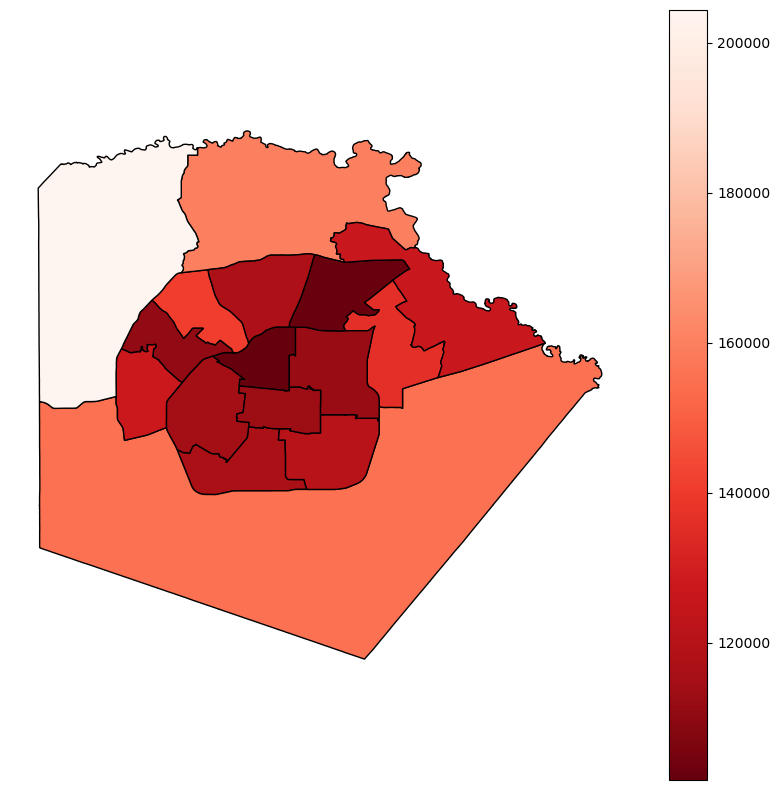

In [26]:
ax = (gdf.plot(column='population_by_sex__estimate_total__K200101_001E',
                     legend=True,
                     cmap='Reds_r',
                     figsize=(10,10),
                     edgecolor='black').
      set_axis_off())

ax